# LDATA2010 Exercise Session - Clustering

Clustering aims at automatically discovering groups of similar samples among data sets. This statement briefly introduces different clustering algorithms. The exercises can be realized using the software of your preference (Python, R, Matlab, etc.). The dataset we will use in this session is based on [transcriptomics data](https://en.wikipedia.org/wiki/Transcriptomics_technologies). As you can see when importing the dataset, the first columns are 300 different gene expressions, and the last column ("cell_type") contains an identifier for the type of the cell.

Each row represents the analysis of *one* cell, and each of the "gene" columns contains (in layman's terms and not wholly accurately) the expression of the gene at one location in the sequence.

## Tools and libraries

To help you implement and test the various clustering algorithms presented during this session, we provide a (non-exhaustive) list of libraries that can be useful. Don't hesitate to look at the documentation for each of these libraries, to get a feel of what they can offer you.

In particular, the `pca_decomposition` function implements PCA, a dimensionality reduction method you will see more thoroughly during the course. We will use it now for 2D visualization, because although we might want to test clustering algorithms in 2D, they start being especially useful with high dimensional data.

> Is it better to first reduce the dimensionality of the dataset and then do clustering or first do clustering and then visualize in a lower dimension ?

<div class="alert alert-success" role="alert">

The choice between reducing dimensionality before clustering versus clustering first and then visualizing in a lower dimension largely depends on your specific goals and the characteristics of your dataset. Here’s a breakdown of both approaches:

### 1. Reducing Dimensionality Before Clustering

#### Pros:
- **Noise Reduction:** Dimensionality reduction techniques (like PCA, t-SNE, or UMAP) can help filter out noise, which can improve clustering results.
- **Computational Efficiency:** Reducing dimensions may speed up clustering algorithms, especially those that are computationally intensive in high dimensions (like k-means).
- **Visualization Ready:** It prepares the data for visualization in 2D or 3D space, which can provide insights into the structure of the clusters.

#### Cons:
- **Information Loss:** Important features might be lost during dimensionality reduction, which can affect clustering performance.
- **Parameter Sensitivity:** Techniques like PCA require choosing the number of components, which can be subjective and may influence results.

### 2. Clustering First and Then Reducing Dimensionality

#### Pros:
- **Preservation of Information:** Clustering algorithms will utilize all original features, potentially yielding more accurate clusters.
- **Interpretability:** Once clusters are formed, visualizing them in a lower dimension can help understand their structure and relationships.

#### Cons:
- **High Dimensionality Challenges:** Clustering in high dimensions can be difficult due to the curse of dimensionality, which may lead to less meaningful clusters.
- **Complexity of Results:** High-dimensional clusters may be hard to interpret or visualize effectively without prior reduction.

### Recommendations:
- **Start with Dimensionality Reduction:** If your dataset has a very high dimensionality (e.g., hundreds of features), it is generally beneficial to first reduce the dimensionality. This approach often leads to more interpretable and meaningful clusters.
  
- **Combine Approaches:** In many cases, a hybrid approach can be beneficial. You can reduce dimensionality first and then cluster the reduced data, followed by visualization of the clustering results. This can provide both the benefits of reduced complexity and better cluster interpretation.

- **Experimentation:** Ultimately, the best approach may depend on the specific dataset and clustering algorithm used. It’s often worthwhile to try both methods and compare the clustering performance and interpretability of the results. Using metrics like silhouette scores or Davies-Bouldin index can help assess clustering quality.

### Conclusion:
While there is no one-size-fits-all answer, reducing dimensionality before clustering is often more effective for high-dimensional datasets, while clustering first can be useful when dealing with lower-dimensional data or when interpretability of the original feature space is critical.


</div>

In [2]:
# Importing the data and nice libraries
import matplotlib.pyplot as plt                   # https://matplotlib.org/
import numpy as np                                # https://numpy.org/doc/1.26/user/index.html#user
import pandas as pd                               # https://pandas.pydata.org/
import seaborn as sns                             # https://seaborn.pydata.org/
from sklearn.decomposition import PCA             # https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
from sklearn.preprocessing import StandardScaler  # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from IPython.display import display, clear_output # https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html

def pca_decomposition(df, components=2):
    """Perform PCA on a dataset.

    PCA is a dimensionality reduction method, which we use to go from 300 dimensions down to 2.
    """
    pca = PCA(n_components=components)
    df2 = pca.fit_transform(df)
    return df2, pca

## Dataset
> **Exercise 1**
> Create a scatter plot of X after PCA in a 2-D space. How many clusters do you intuitively observe ? Do you think these clusters are present in the 300-dimension space ?

In [3]:
# BEGIN - Add theses lines to avoid SSL error when downloading the dataset
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
# END - Add theses lines to avoid SSL error when downloading the dataset

url_dataset = "https://gist.githubusercontent.com/victorjoos/34b43873616f253451af610ca8460ddf/raw/ad9b89f72c6c67318e08de13871c34d56fbae259/transcriptomics_data.csv"
dataframe = pd.read_csv(url_dataset)

y = dataframe["cell_type"] # Keep the target variable
X = dataframe.drop(columns=["cell_type"]).to_numpy() # Keep all features

X_pca, pca = pca_decomposition(X, 3)

print("Dataset shape before PCA :", X.shape)
print("Dataset shape after PCA :", X_pca.shape)

Dataset shape before PCA : (4765, 300)
Dataset shape after PCA : (4765, 3)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


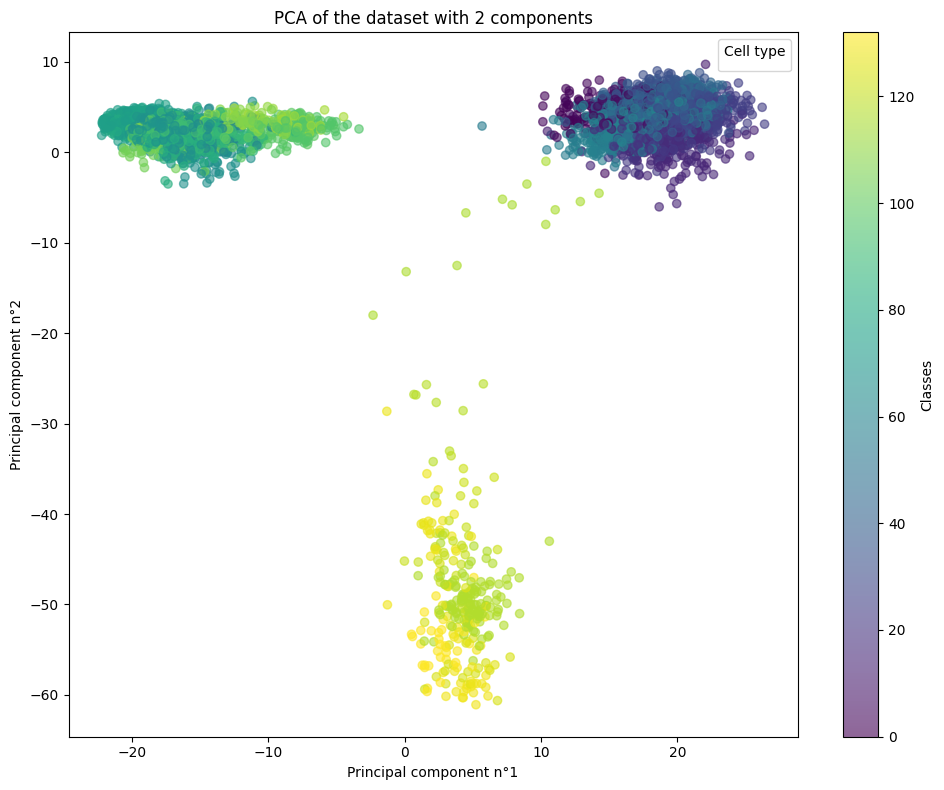

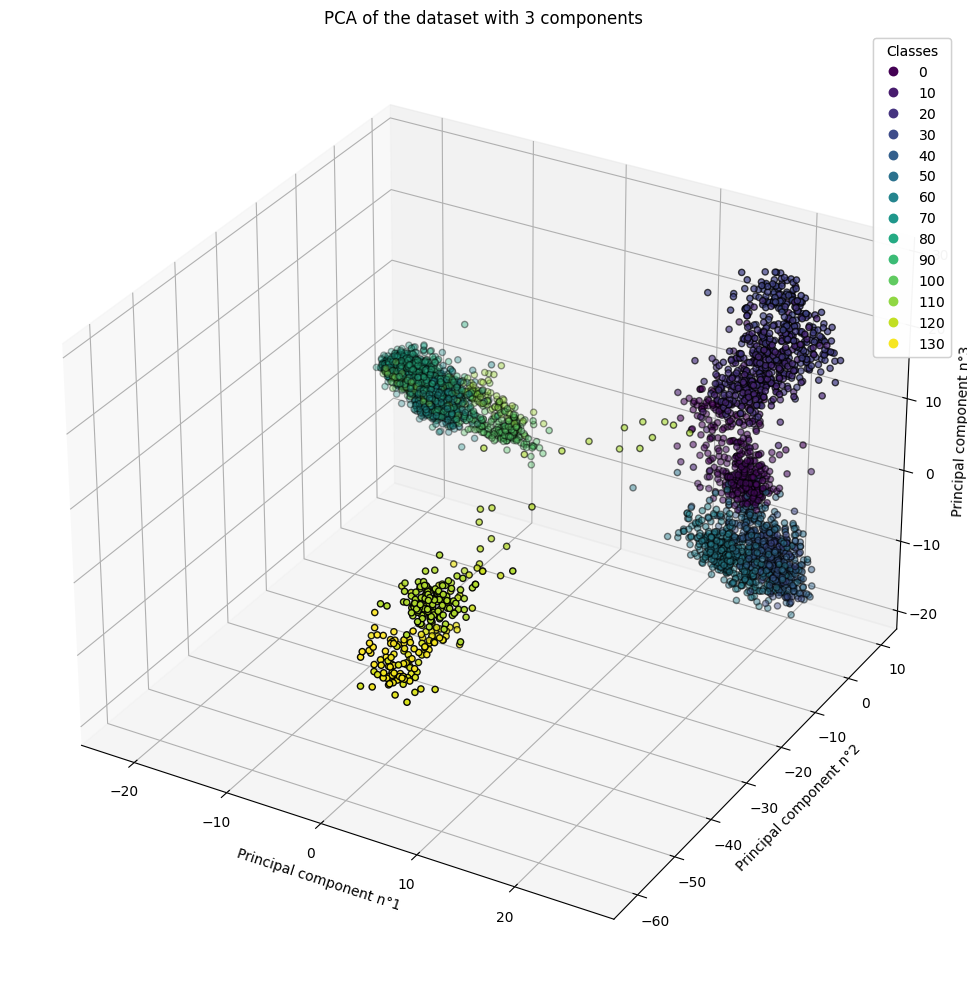

In [4]:
# TODO : Plot the PCA with 2 and 3 components

# 2D plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(x=X_pca[:, 0], y=X_pca[:, 1], c=y, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Classes')
plt.xlabel("Principal component n°1")
plt.ylabel("Principal component n°2")
plt.title("PCA of the dataset with 2 components")
plt.legend(title="Cell type")
plt.tight_layout()
# plt.savefig("Figures/PCA_2Components.png")
plt.show()

# 3D plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap='viridis', edgecolors='k')
legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend1)
ax.set_title('PCA of the dataset with 3 components')
ax.set_xlabel('Principal component n°1')
ax.set_ylabel('Principal component n°2')
ax.set_zlabel('Principal component n°3')
plt.tight_layout()
# plt.savefig("Figures/PCA_3Components.png")
plt.show()

## K-means

The K-means algorithm may be summarized as follows : given,
 - a set $ D = \{x_1, ..., x_N\} $ of N data points with dimension H,
 - a distance function d,
 - a number K of clusters,

it defines a set $ C = {c_1, ..., c_K}$  of K centroids with dimension H. After initializing the centroids according to some heuristic (e.g. randomly in the data space, randomly in D, etc.), the centroid coordinates are updated according to the following scheme:

 1. For each $ i \in \{1, ..., K\} $, compute $ D_i = \{x_j \in D | i = \mathrm{argmin}_{l\in{1, ..., K}} d(c_l, x_j)\} $
 2. For each $ i \in \{1, ..., K\} $, set $c_i \leftarrow \frac{1}{ | D_i | } \sum_{x\in D_i}{x}$

Computing steps 1 and 2 corresponds to performing *one* iteration. Iterations are repeated until convergence of the centroids or after a maximum number has been reached. The clusters are then defined as the sets $D_i$ for $i\in\{1, ..., K\}$

> **Exercise 2** Implement the K-means algorithm with Euclidian distance and apply it to X with K = 3 clusters and with the centroids chosen at random from the dataset. After each iteration, show the new clusters and centroids. How many iterations are needed before convergence ? Does the result seem intuitive ?
>
> What happens when you change K ?
>
> Do all the cells with the same cell type go in the same cluster ? How would you visualize this ?
>
> Does K-Means work even when the initial centroids are all in the same cluster ?
>
> Do you get the same result when doing the clustering on `X_pca` ?

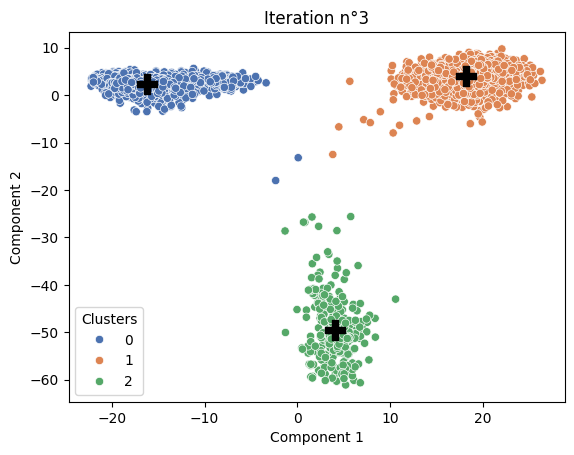

In [28]:
import time

fig, ax = plt.subplots(1) # Create a figure and a single subplot for the visualization

def initialize_centroids(X, K, method='random'):
    """Randomly select K initial centroids from the dataset or use K-means++."""
    if method == 'random':
        initial_indices = np.random.choice(len(X), size=K, replace=False)
        return X[initial_indices]
    
    # TODO : Implement the K-means++ initialization method
    elif method == 'kmeans++':
        centroids = [X[np.random.choice(len(X))]]  # Start with a random centroid
        
        for _ in range(1, K):
            # Compute the distance to the nearest centroid for each point
            distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
            min_distances = np.min(distances, axis=1)
            # Use squared distances for the probabilities
            probabilities = min_distances ** 2  
            probabilities /= probabilities.sum()  # Normalize to sum to 1
            
            # Choose the next centroid based on the computed probabilities
            next_centroid = X[np.random.choice(len(X), p=probabilities)]
            centroids.append(next_centroid)
            
        return np.array(centroids)
    else:
        raise ValueError("Unknown method")

def kmeans_iteration(X, centroids):
    """Perform one iteration of the k-means algorithm."""
    distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
    clusters = np.argmin(distances, axis=1)
    centroids = np.array([X[clusters == k].mean(axis=0) for k in range(centroids.shape[0])])
    return clusters, centroids

def visualize_kmeans_iteration(X_pca, clusters, centroids, iteration, delay=0.5):
    """Visualize the current state of the K-means algorithm."""
    ax.cla()
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette="deep", ax=ax, legend='full')
    C_pca = pca.transform(centroids)
    ax.scatter(C_pca[:, 0], C_pca[:, 1], c="black", marker="P", s=200)  # Centroids
    ax.set_title(f'Iteration n°{iteration}')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    plt.legend(title='Clusters')
    display(fig)
    time.sleep(delay)
    clear_output(wait=True)

def kmeans(X, K=3, max_iter=10, init_method='random', visualize=True):
    """Run the K-means algorithm and optionally visualize the results."""
    centroids = initialize_centroids(X, K, method=init_method)
    for i in range(1, max_iter + 1):

        clusters, new_centroids = kmeans_iteration(X, centroids)
        if np.allclose(centroids, new_centroids): break
        centroids = new_centroids

        if visualize: visualize_kmeans_iteration(X_pca, clusters, centroids, i)

    return clusters, centroids, i

clusters, final_centroids, iterations = kmeans(X, K=3, max_iter=20, init_method='kmeans++', visualize=True)

## Nearest neighbor clustering
Given a set $ D = \{x_1, ..., x_N\}$ of $N$ data points, a distance function $d$ and a threshold $t$, nearest neighbor clustering defines clusters in $D$ in the following way :

 - Define $C_1 = \{x_1\}, C= \{C_1\}$ and $K = 1$;
 - For $i = 2,..., N$,
  1. Compute $j = \mathrm{argmin}_{l\in\{1,...,i-1\}}d(x_l,x_i)$
  2. If $d(x_j, x_i) \ge t$ set $K\leftarrow K + 1$, define $C_K = {x_i}$ and set $C \leftarrow C \cup \{C_K\}$
  3. Otherwise, identify $k\in {1, ..., K}$ such that $x_j \in C_k$ and set $C_k \leftarrow C_k \cup \{x_i\}$

Whereas K-means needs the user to specify the desired number K of clusters, nearest neighbor clustering instead requires to define a threshold $t$ for the minimum distance between two clusters.

> **Exercise 3** Implement nearest neighor clustering with the Euclidian distance and apply it to X, using a threshold t = 5. Do you obtain the same result as when using K-means ? Does the order of the dataset matter ?
>
> How does the algorithm change when using a different threshold ? What is the threshold range where you get 3 clusters ?

In [ ]:
def nneighbor_iteration(X, i, clusters, threshold):
    # 1. compute the index of the closest neighbor
    j = i-1 # CHANGME
    # 2. update the clusters
    clusters[i] = clusters[j] # CHANGME : take care of the threshold
    return clusters

threshold = 5 # CHANGME ?
clusters = np.ones(len(X), dtype=int) * -1 # init all nodes to to a negative index ("unassigned")
clusters[0] = 0 # create the first cluster

##  Visualization
display_every_n = 100 # CHANGME ?

fig, ax = plt.subplots(1)

for i in range(1, len(X)):
    clusters = nneighbor_iteration(X, i, clusters, threshold)
    if (i % display_every_n) == 0 or i == len(X)-1:
      ax.cla()
      sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters[:], palette="deep", ax=ax)
      # Alternative, to display only assigned nodes :
      # sns.scatterplot(x=X_pca[:i,0], y=X_pca[:i,1], hue=clusters[:i], palette="deep", ax=ax)
      display(fig)
      clear_output(wait=True)